# Testing skill of single CMIP6 climate model 
Using 10 years of historical simulation (2005-2014) and 10 years of SSP245 (2015-2024) monthly data. Comparing to ERA5 montly data.

In [ ]:
import xarray as xr
import pandas as pd
import xesmf as xe
import xskillscore as xs
import matplotlib.pyplot as plt

In [ ]:
# dataset with the area of each pixel for this model
arecella_ds = xr.open_zarr(
    "gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r10i1p1f1/fx/areacella/gr/v20180803",
    chunks={}, 
    consolidated=True,
)
# historical simulation dataset
historical_ds = xr.open_zarr(
    "gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Amon/tas/gr/v20180803",
    chunks={}, 
    consolidated=True,
).sel(time=slice('2005-01-01','2014-12-31'))
# ssp245 projection dataset
historical_ds['time'] = pd.to_datetime(historical_ds['time'].dt.strftime('%Y-%m-01')) # setting to the first of the month to match with era5
ssp245_ds = xr.open_zarr(
    "gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR/ssp245/r1i1p1f1/Amon/tas/gr/v20190119",
    chunks={}, 
    consolidated=True,
).sel(time=slice('2015-01-01','2024-12-31'))
ssp245_ds['time'] = pd.to_datetime(ssp245_ds['time'].dt.strftime('%Y-%m-01')) # setting to the first of the month to match with era5

In [ ]:
# era5 data downloaded manually from: https://cds.climate.copernicus.eu/requests?tab=all
# zipped copy saved on google drive: https://drive.google.com/file/d/1n8ceKqAjTfZ-Jz4MRHFT0MfjaXd73VEW/view?usp=drive_link
era5_ds = xr.open_zarr('era5_monthly_tas.zarr',chunks={})

/var/folders/ys/qmftlyyx3dj63021dv4205g80000gn/T/ipykernel_88840/2636499714.py:6: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  era5_ds = xr.open_zarr('era5_monthly_tas.zarr',chunks={})


In [52]:
# regrid era5 data to resolution of CMIP model
regridder = xe.Regridder(era5_ds, historical_ds[['lat','lon']], "bilinear")
era5_rg_ds = regridder(era5_ds['tas'], keep_attrs=True).to_dataset(name='tas')

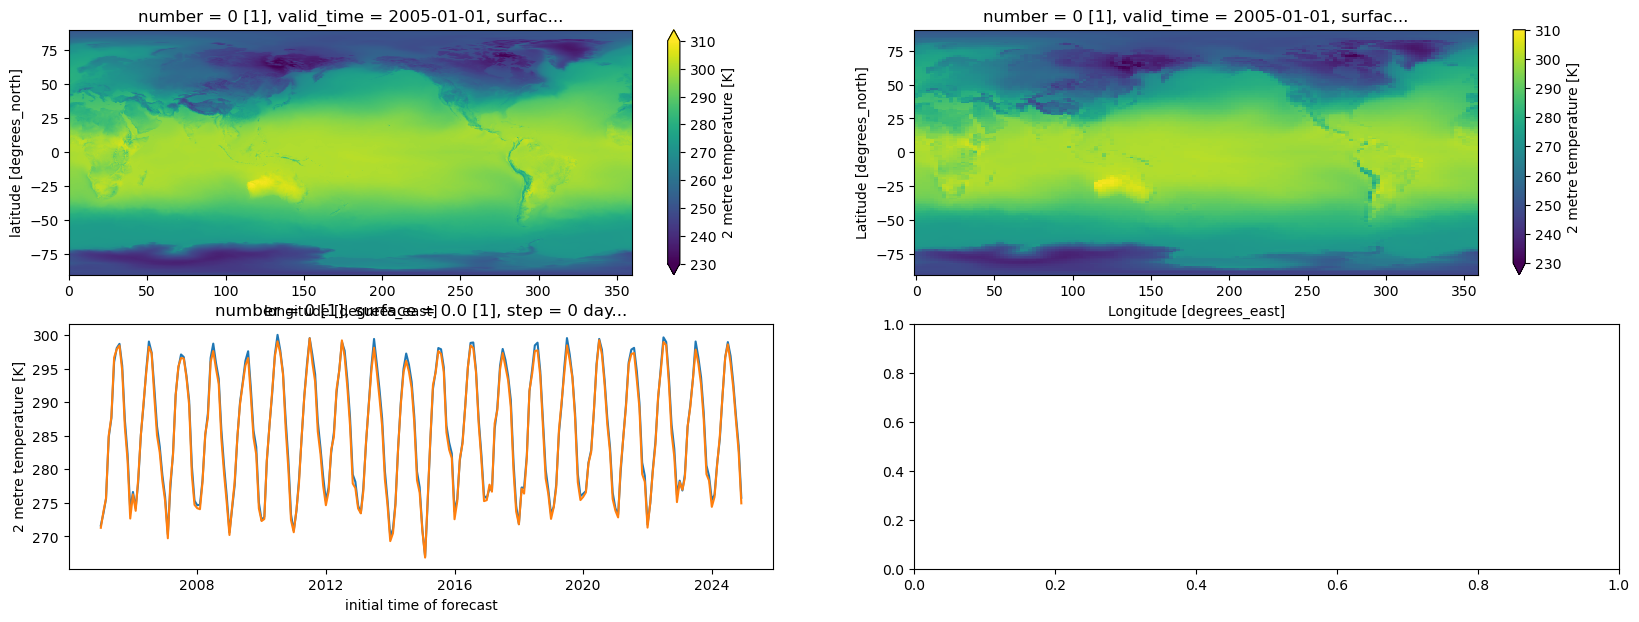

In [53]:
fig, ax = plt.subplots(2,2,figsize=(20,7))

# plot map for first time step
era5_ds['tas'].isel(time=0).plot(ax=ax[0,0],vmin=230,vmax=310)
era5_rg_ds['tas'].isel(time=0).plot(ax=ax[0,1],vmin=230,vmax=310)
# plot time series for roughly nyc
era5_ds['tas'].sel(lat=40.7128,lon=285.994,method='nearest').plot(ax=ax[1,0])
era5_rg_ds['tas'].sel(lat=40.7128,lon=285.994,method='nearest').plot(ax=ax[1,0])

In [54]:
# take area weighted mean and compare model to era5 (regridded)
weights_da = arecella_ds['areacella']/arecella_ds['areacella'].sum()
historical_weighted_mean_ds = (historical_ds['tas']*weights_da).sum(dim=['lat','lon'])
ssp245_weighted_mean_ds = (ssp245_ds['tas']*weights_da).sum(dim=['lat','lon'])
era5_weighted_mean_ds = (era5_rg_ds['tas']*weights_da).sum(dim=['lat','lon'])

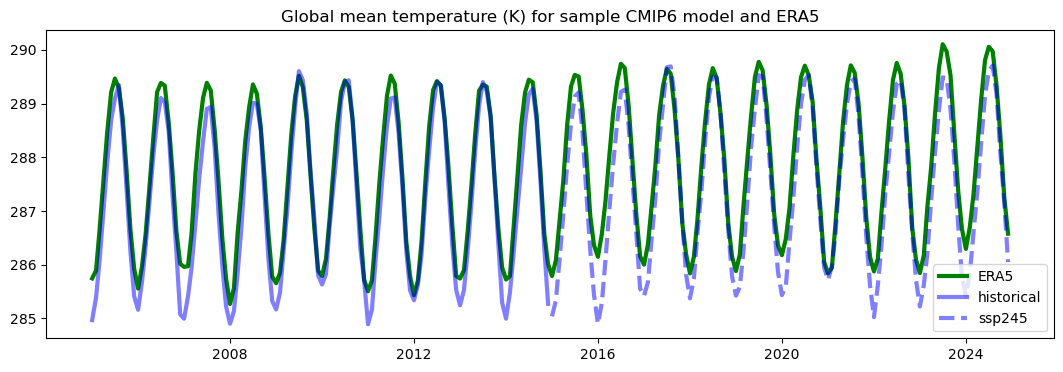

In [55]:
fig, ax = plt.subplots(figsize=(13,4))
era5_weighted_mean_ds.plot(ax=ax,color='green',linestyle='-',linewidth=3,alpha=1,label='ERA5')
historical_weighted_mean_ds.plot(ax=ax,color='blue',linestyle='-',linewidth=3,alpha=0.5,label='historical')
ssp245_weighted_mean_ds.plot(ax=ax,color='blue',linestyle='--',linewidth=3,alpha=0.5,label='ssp245')
ax.set_xlabel('')
ax.set_title('Global mean temperature (K) for sample CMIP6 model and ERA5')
ax.legend()

In [56]:
historical_rmse = xs.rmse(era5_weighted_mean_ds.sel(time=slice('2005-01-01','2014-12-31')),historical_weighted_mean_ds).compute()
ssp245_rmse = xs.rmse(era5_weighted_mean_ds.sel(time=slice('2015-01-01','2024-12-31')),ssp245_weighted_mean_ds).compute()

print(f'historical simulation RMSE:   {historical_rmse.values}')
print(f'SSP245 RMSE:                  {ssp245_rmse.values}')

historical simulation RMSE:   0.4241902828216553
SSP245 RMSE:                  0.551315426826477
